In [1]:
import jax 
import numpy as np
import jax.numpy as jnp

from jax import random
from tqdm import tqdm

In [2]:
## Lorenz parameters
S = 10
R = 28
B = 8/3

## Simulation parameters
h = 1e-3                            # time step for euler discretisation 
c = 1/10                            # parameter in obs operator  
M = 40;							    # gap between observations (in multiples of h)
Tf = 20;							# final time
NT = int(Tf/h);  #1+floor(Tf/h);	# no. of discrete time steps
sx = 0.05;							# scale of signal noise
sy = 1;                             # std of observation noise
s2o = 1;							# initial variance
#NR = 1;                             # no. of repetitions of the simulation
#sw = [1 1];                        # algorithms to run: sw(1) is BF, sw(2) is CKF
npts = 20;                          # no. of points in each dimension in grid
NP = 1000;                          # no. of particles, needs to be increased to 10^6 
d = 3;                              # dimension of state vector 
p = 2;                              # dimension of observation vector 
comppost = 1;                       #= 1 means to compute posterior, = 0 means only compute fokker planck
XR0 = jnp.array([[-5.91652], [-5.52332], [24.5723]])               # reference initial condition (also prior mean)

XR02 = jnp.array([[5.91652], [5.52332], [24.5723]])               # other mode of initial distribution 

ZR0 = jnp.zeros((p, 1))


# Grid extents
extents = jnp.array([[-20, 20],
                     [-30, 20],
                     [0, 50]])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
idy = jnp.arange(0, NT, M)

$$
\nu(\mathbf{x}) = A_1 \mathbf{x} + \mathbf{x}^T A_2 \mathbf{x} a_1^T +  \mathbf{x}^T A_3  \mathbf{x} a_2^T
$$

In [4]:
import time
key = random.PRNGKey(int(time.time()))  # Random seed is explicit in JAX

In [5]:
# Matrices
A1 = jnp.array([[-S, S, 0], [R, -1, 0], [0, 0, -B]])
A2 = jnp.zeros((3, 3)).at[0, 2].set(-1)
A3 = jnp.zeros((3, 3)).at[0, 1].set(1)

# Vectors
a1 = jnp.zeros((3, 1)).at[1, 0].set(1)
a2 = jnp.zeros((3, 1)).at[2, 0].set(1)

@jax.jit
def nu(X):
    mat1  = A1 @ X
    mat2 = jnp.sum((X.T @ A2) * X.T, axis=1) * a1
    mat3 = jnp.sum((X.T @ A3) * X.T, axis=1) * a2
    return  mat1 + mat2 + mat3

def hobs_l63(X, c):
    Z = jnp.zeros((p, X.shape[-1]))
    Z.at[0, :].set(c*X[0, :]*X[1,:])
    Z.at[1, :].set(c*X[2, :])
    return Z

In [6]:
@jax.jit
def time_update(carry, t):
    XR = carry['XR']
    ZR = carry['ZR']
    carry['ZR'] = ZR + h*hobs_l63(XR, c) + np.sqrt(h)*random.normal(key=key, shape=(p,1))
    XR = XR + h*nu(XR) + sx*np.sqrt(h)*random.normal(key=key, shape=(d, 1))
    carry['XR'] = XR
    return carry, carry


In [7]:
# Define timesteps and carry vectors
t = jnp.arange(NT)
carry = {
    'XR': XR0,
    'ZR': ZR0
}

# Lorenz 63 simulation
carry_out, out = jax.lax.scan(time_update, carry, t)

# Process outputs
XR = out['XR'].T.reshape((d, -1))
ZR = out['ZR'].T.reshape((p, -1))

ZL = ZR[:, idy]

# Gradient computation
dZdttemp = jnp.diff(ZL, axis=1)/(M*h)
dZdt = jnp.repeat(dZdttemp, M, axis=1)
dZdt = jnp.concatenate([dZdt, jnp.empty(shape=(p, M))], axis=1)

In [8]:
# Mesh grid
points = [jnp.linspace(*extents[i], npts) for i in range(d)]
mesh = jnp.stack(jnp.meshgrid(*points), axis=-1)

In [9]:
@jax.jit
def evolve_particles(carry, ts):
    XT = carry['XT']
    carry['XT'] = XT + h*nu(XT) + sx*np.sqrt(h)*random.normal(key=key, shape=(d, NP))
    return carry, XT

@jax.jit
def computepdf(X):
    bw = 0.1
    return jax.scipy.stats.multivariate_normal.pdf(
                mesh, mean=X, cov=bw*jnp.identity(d)
    )

@jax.jit
def fokker_planck(carry, idx):
    ts = jnp.arange(M)
    carry, _ = jax.lax.scan(evolve_particles, carry, ts)
    carry['priorpdf'] = jnp.apply_along_axis(computepdf, 
                                             axis=0, 
                                             arr=carry['XT']).sum(axis=-1)
    return carry, carry['priorpdf']


In [10]:
# Initial pdf
cov = jnp.identity(d) * s2o
XP1 = random.multivariate_normal(mean=XR0.flatten(), 
                           cov=cov, 
                           shape=(int(NP/2),), 
                           key=key).T
XP2 = random.multivariate_normal(mean=XR02.flatten(), 
                           cov=cov, 
                           shape=(int(NP/2),), 
                           key=key).T

XP = jnp.concatenate([XP1, XP2], axis=1)
priorpdf = jnp.apply_along_axis(computepdf, axis=0, arr=XP).sum(axis=-1)

# Define timesteps and carry vectors
idx = jnp.arange(len(idy)-1)
carry = {
    'XT': XP,
    'priorpdf': priorpdf
}

carry_out, priorpdfout = jax.lax.scan(fokker_planck, carry, idx)


# Xtrue = XR[:, idy]


# XT = carry_out['XT']

In [11]:
xmesh = mesh[:, :, :, 0]
ymesh = mesh[:, :, :, 1]
zmesh = mesh[:, :, :, 2]

In [12]:
def scale(x):
    x_max = x.max()
    x_min = x.min()
    return (x - x_min)/(x_max - x_min)

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


MovieWriter stderr:
convert-im6.q16: cache resources exhausted `/project/mcsim/fokkerplanck.gif' @ error/cache.c/OpenPixelCache/4095.
convert-im6.q16: memory allocation failed `/project/mcsim/fokkerplanck.gif' @ error/quantize.c/AssignImageColors/498.



CalledProcessError: Command '['convert', '-size', '640x480', '-depth', '8', '-delay', '1.6666666666666667', '-loop', '0', 'rgba:-', '-layers', 'OptimizePlus', '/project/mcsim/fokkerplanck.gif']' returned non-zero exit status 1.

0


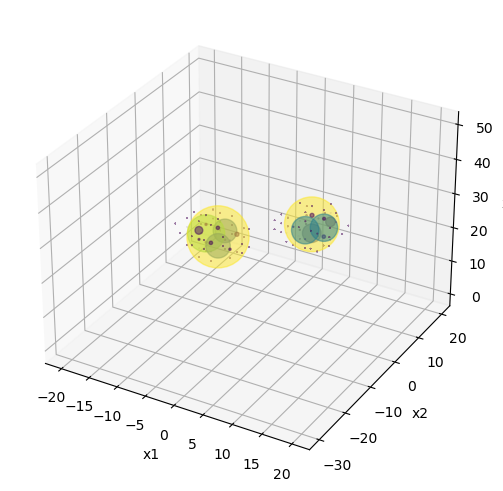

In [13]:

import sys
import matplotlib.pyplot as plt
import matplotlib as mlp
from matplotlib.animation import FFMpegWriter, FuncAnimation


cmap = plt.cm.viridis

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), constrained_layout=True)

x = xmesh.ravel()
y = ymesh.ravel()
z = zmesh.ravel()
p0 = priorpdf.ravel()

norm = mlp.colors.Normalize(vmin=p0.min(), vmax=p0.max())
scat = ax.scatter(x, y, z, s=scale(p0)*2000, color=cmap(norm(p0)), alpha=0.5)

# ax.set_zlim([0,np.max(Pt)/3])
ax.autoscale(False)

def update(i):
    global scat
    scat.remove()
    print(i)
    scat = ax.scatter(x, y, z, 
                      s=scale(priorpdfout[i])*2000,
                      color=cmap(norm(priorpdfout[i].ravel())), 
                      alpha=0.5)
    return [scat]

anim = FuncAnimation(fig, update, frames=range(len(idy)-1), interval=1)
ax.set(xlabel='x1', ylabel='x2', zlabel='x3')

# # saving to m4 using ffmpeg writer
anim.save('/project/mcsim/fokkerplanck.gif', writer='imagemagick', fps=60) 

plt.close()